# Extrinsics Calibration

In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

from dt_computer_vision.camera import CameraModel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

In [2]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image1.jpg")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]]
}
camera = CameraModel(**camera_properties)

assert image.shape == (480, 640, 3)

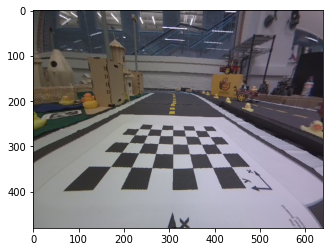

In [3]:
# rectify image
image = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [4]:
# find corners
corners = find_corners(image, board)
print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns - 1) * (board.rows - 1)

Found 35 corners.


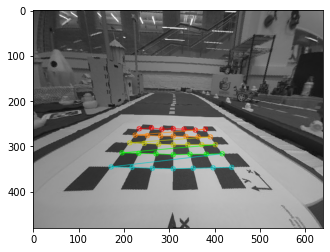

In [5]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image, board, corners)
image_w_corners = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners)

In [6]:
# estimate homography
H = estimate_homography(corners, board, camera)

In [7]:
# project the principal point onto the plane
ground_pp = np.dot(H, [0, 0, 1])
ground_pp = (ground_pp / ground_pp[2])[:2]
# manually measured when the image above was taken
expected_pp = [0.4, 0]

# compute error estimate
error = np.linalg.norm(np.abs(ground_pp - expected_pp))
print(f"Error is ~{error * 100:.2f}cm.")

# make sure the error is within 3cm
assert error <= 0.03

Error is ~2.61cm.


In [8]:
print(H)

[[-2.42749970e-02  9.46389079e-02  3.81909422e-01]
 [-4.55028567e-01 -1.17673909e-03 -1.87813039e-02]
 [-1.46006785e-01  3.29784838e+00  1.00000000e+00]]


# Ground Reprojection

In [9]:
from typing import List
from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection.types import GroundPoint

# image corners, detected above
image_corners: List[NormalizedImagePoint] = [
    camera.pixel2vector(c) for c in corners
]

# ground points, easily reconstructable given a known board
ground_corners: List[GroundPoint] = []
board_offset = np.array([board.x_offset, board.y_offset])
square_size = board.square_size
for r in range(board.rows - 1):
    for c in range(board.columns - 1):
        src_corner = np.array([(r + 1) * square_size, (c + 1) * square_size]) + board_offset
        ground_corners.append(GroundPoint(*src_corner))
# OpenCV labels corners left-to-right, top-to-bottom, let's do the same
ground_corners = ground_corners[::-1]

# make sure the corners match in size
assert len(image_corners) == len(ground_corners)

errors = []
for i, (image_corner, ground_corner) in enumerate(zip(image_corners, ground_corners)):
    # project image point onto the ground plane
    ground_corner_computed = np.dot(H, [image_corner.x, image_corner.y, 1])
    ground_corner_computed = (ground_corner_computed / ground_corner_computed[2])[:2]
    ground_corner_computed_p = GroundPoint(round(ground_corner_computed[0], 3), round(ground_corner_computed[1], 3))
    print(f"{i}\t: I[{image_corner}] -> Gc[{ground_corner_computed_p}] ~ G[{ground_corner}]: ", end="")
    # print out error
    error = np.linalg.norm(np.abs(ground_corner_computed - ground_corner.as_array()))
    print(f"{float(error):.5f}")
    # store error
    errors.append(error)

# compute average error
avg_error = np.average(errors)
std_error = np.std(errors)
print(f"Overall error: {avg_error} +/- {std_error}")

0	: I[P(-0.2934271590551761, 0.06445181817602502)] -> Gc[P(0.315, 0.091)] ~ G[P(0.315, 0.093)]: 0.00168
1	: I[P(-0.20474569504535764, 0.05922456603843115)] -> Gc[P(0.32, 0.061)] ~ G[P(0.315, 0.062)]: 0.00551
2	: I[P(-0.12484480588619926, 0.06637269859784262)] -> Gc[P(0.316, 0.031)] ~ G[P(0.315, 0.031)]: 0.00128
3	: I[P(-0.04086866197007527, 0.06575763786237467)] -> Gc[P(0.318, -0.0)] ~ G[P(0.315, 0.0)]: 0.00322
4	: I[P(0.04090209851098805, 0.06701139592278026)] -> Gc[P(0.319, -0.031)] ~ G[P(0.315, -0.031)]: 0.00373
5	: I[P(0.12478838048044578, 0.07495848595900796)] -> Gc[P(0.314, -0.062)] ~ G[P(0.315, -0.062)]: 0.00104
6	: I[P(0.197587906090827, 0.06899656379268138)] -> Gc[P(0.32, -0.091)] ~ G[P(0.315, -0.093)]: 0.00553
7	: I[P(-0.32668366239066815, 0.11207027470901003)] -> Gc[P(0.283, 0.092)] ~ G[P(0.28400000000000003, 0.093)]: 0.00206
8	: I[P(-0.2324733157277255, 0.11587270915809648)] -> Gc[P(0.281, 0.061)] ~ G[P(0.28400000000000003, 0.062)]: 0.00266
9	: I[P(-0.13724854014331794, 0.1